#### Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
from razdel import sentenize

In [3]:
import random

In [4]:
from tqdm import tqdm

In [5]:
import re
import os

#### Visualisation

In [6]:
import matplotlib
import matplotlib.pyplot as plt

In [7]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

## "Капитанская дочка" (1833-1836), А.С. Пушкин

In [8]:
pushkin_raw_dir = '../data/raw/pushkin'
dochka_filename = 'kapitanskaya_dochka.txt'  # ~ 383 KB

In [9]:
with open(os.path.join(pushkin_raw_dir, dochka_filename), 'r') as file:
    dochka_raw = file.read()

### Splitting by chapters

Every **chapter** in the book is starting from a paragraph:

    (\n\n)
    ГЛАВА XIII(\n)
    АРЕСТ(\n)
    Не гневайтесь, сударь: по долгу моему(\n)
    Я должен сей же час отправить вас в тюрьму.(\n)
    — Извольте, я готов; но я в такой надежде,(\n)
    Что дело объяснить дозволите мне прежде.(\n)
    Княжнин.(\n)
    (\n\n)
    
with two `\n` before the paragraph and two `\n` after. Let's split chapters and remove that paragraphs with chapters names and with epigraphs.

**The additional chapter** (in the end of file) having another header:

    (\n)
    ПРИЛОЖЕНИЕ(\n)
    ПРОПУЩЕННАЯ ГЛАВА *(\n)

with onl one `\n` before the chapter's content.

In [10]:
# also chapters can be detected by their length!
chapter_length_th = 1000  # chapter length threshold

chapter_num = 1
for prt in re.split('\n\n', dochka_raw):
    if len(prt) > chapter_length_th:
        print(f'{len(prt)}\t<- Chapter {chapter_num}')
        chapter_num += 1
    else:
        print(len(prt))

67
229
14064	<- Chapter 1
233
15620	<- Chapter 2
210
10162	<- Chapter 3
101
14666	<- Chapter 4
280
12568	<- Chapter 5
101
17065	<- Chapter 6
334
11699	<- Chapter 7
66
13516	<- Chapter 8
134
8004	<- Chapter 9
199
13044	<- Chapter 10
148
18081	<- Chapter 11
189
10972	<- Chapter 12
191
11195	<- Chapter 13
55
19091	<- Chapter 14
13
19531	<- Chapter 15


In [11]:
chapters_list = []  # list with chapters text (with replaced '\n' by ' ')

for text_part in re.split('\n\n', dochka_raw):  # includes paragraphs with chapter's numbers and epigraphs
    if len(text_part) > chapter_length_th:
        if re.search('(ГЛАВА.+)\n', text_part):  # clean last additional chapter from the header
            chapters_list.append(re.split('(ГЛАВА.+)\n', text_part)[-1].replace('\n', ' '))
        else:
            chapters_list.append(text_part.replace('\n', ' '))  # add chapter text without '\n'

In [12]:
print(f'Number of chapters: {len(chapters_list)}')

Number of chapters: 15


### Splitting by sentences

Let's try to use [`razdel`](https://github.com/natasha/razdel) to atomize chapters by sentences. It seems really good solution!

#### Example

In [13]:
chapter_number = 7
test_chapter_text = chapters_list[chapter_number - 1]

In [14]:
subs_gen = sentenize(test_chapter_text)  # generator of Substrings
subs_list = list(subs_gen)

In [15]:
print(f'Number of sentences in Chapter {chapter_number}: {len(subs_list)}')

Number of sentences in Chapter 7: 184


In [16]:
# Substring example
random_subs = random.choice(subs_list)
random_subs

Substring(4324,
          4392,
          '— Здесь не бабье дело; уведи Машу; видишь: девка ни жива ни мертва».')

In [17]:
# way to apply to sentence text
random_subs.text

'— Здесь не бабье дело; уведи Машу; видишь: девка ни жива ни мертва».'

In [18]:
# another way to apply to the sentence
test_chapter_text[random_subs.start:random_subs.stop]

'— Здесь не бабье дело; уведи Машу; видишь: девка ни жива ни мертва».'

#### Number of sentences in each Chapter

In [20]:
num_sentences_by_chapters = []

for chapter_number in range(len(chapters_list)):
    num_sentences_by_chapters.append(len(list(sentenize(chapters_list[chapter_number]))))
    print(f'Chapter {chapter_number + 1}:\t {num_sentences_by_chapters[-1]}')

print(f'\nTotal number of sentences: {sum(num_sentences_by_chapters)}')

Chapter 1:	 190
Chapter 2:	 246
Chapter 3:	 144
Chapter 4:	 214
Chapter 5:	 161
Chapter 6:	 208
Chapter 7:	 184
Chapter 8:	 198
Chapter 9:	 123
Chapter 10:	 164
Chapter 11:	 279
Chapter 12:	 189
Chapter 13:	 183
Chapter 14:	 212
Chapter 15:	 345

Total number of sentences: 3040


### Sentence cleaning

We will restrict our model to prediction of `,` (commas) within a sentence and `!` (exclamation point), `?` (question mark) and `.` (periods) in the end of a sentence.

Hence a **processing of other punctuation** is as following:
1. substitute of `:` (colon) or `;` (semicolon) by `,` (comma);
2. substitute of `!` and `?` in the middle of a sentence by `,` (comma);
3. substitute of `—` (dash) by `,` (comma) in the middle of a sentence;
4. delete `—` in the beginning of a sentence;
5. delete all `"'«»` (quotes).

Additional symbols:
1. there is some info in periods `()` in the book text - delete it (or leave if it is a complete sentence);
2. all `*` must be deleted.

In [21]:
def process_sentence(sentence):
    # THIS FUNCTION WAS LATER FIXED IN `processing.py`!
    # final data preparation for `kapitanskaya_dochka` was done with `pushkin_common.ipynb`!
    
    subs_by_comma = ['? ', '! ', ': ', ', — ', ' — ', '; ']  # substitute by ', '
    quotes_arr= ['"', "'", '«', '»', '*']
    cases_arr = ['(', ')', '[', ']']

    sentence = sentence.lower()  # lowercase
    
    # deleting of a dash in the beginning of the sentence
    if sentence[0] == '—':
        sentence = sentence[2:]
    
    # deleting of text in cases: '[*]' and the '(*)'
    sentence_no_cases = re.sub('[\(\[].*?[\)\]]', '', sentence)
    if len(sentence_no_cases) < 2:  # check if we have not deleted complete sentence
        for case in cases_arr:
            sentence = sentence.replace(case, '')
    else:
        sentence = sentence_no_cases
        
    # deleting of quotes
    for quote in quotes_arr:
        sentence = sentence.replace(quote, '')

    # punctuation in the end of the sentence can be multiple
    # for example: '...', '!..', '?..'
    # convert to:  '.', '!' and '?'
    n_of_last_punct = 0
    for char in sentence[::-1]:
        if bool(re.search('[а-яА-Я]', char)):
            break
        else:
            n_of_last_punct += 1
    for mark in sentence[-n_of_last_punct:]:
        if not mark == ' ':  
            last_punct = mark  # only one punctuation mark in the end
            break
    if last_punct == ';':
        last_punct = '.'  # last mark of the sentence cant be a ';'
    sentence = sentence[:-n_of_last_punct]  # delete final punctuation (add it in the end)
    
    # substitute of all punctuation within the sentence by ',' (comma)
    for mark in subs_by_comma:
        sentence = sentence.replace(mark, ', ')

    # delete all periods within the sentence
    sentence = sentence.replace('.', '')

    # check if the first symbol is space - delete it
    if sentence[0] == ' ':
        sentence = sentence[1:]

    # replace all multiple spaces by single space ' '
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # save edited sentence (adding the punctuation in the end of sentence)
    return sentence + last_punct

In [22]:
%%time

all_sentences_raw = []
all_sentences_processed = []
all_sentences_lengths = []

for chapter_number in range(len(chapters_list)):
    for substring in sentenize(chapters_list[chapter_number]):
        sentence = substring.text
        all_sentences_raw.append(sentence)
        
        processed_sentence = process_sentence(sentence)  # process sentence
        len_processed = len(processed_sentence.split(' '))  # find length of the sentence
        all_sentences_processed.append(processed_sentence)
        all_sentences_lengths.append(len_processed)

CPU times: user 88.4 ms, sys: 6.85 ms, total: 95.3 ms
Wall time: 253 ms


#### DataFrame with sentences

In [23]:
dochka_sent_df = pd.DataFrame()

dochka_sent_df['raw'] = all_sentences_raw
dochka_sent_df['processed'] = all_sentences_processed
dochka_sent_df['len'] = all_sentences_lengths

In [24]:
dochka_sent_df.shape

(3040, 3)

In [25]:
pd.options.display.max_colwidth = 200
dochka_sent_df.sample(5)

,raw,processed,len
2247,Мы говорили и не могли наговориться.,мы говорили и не могли наговориться.,6
517,Мы тотчас познакомились.,мы тотчас познакомились.,3
1606,"— Это что еще! — вскричал Пугачев, сверкнув огненными глазами.","это что еще, вскричал пугачев, сверкнув огненными глазами.",8
2808,"Я спешил их вывести из заключения, — но, подошед к двери, я нашел ее снова запертою.","я спешил их вывести из заключения, но, подошед к двери, я нашел ее снова запертою.",15
462,"Она разматывала нитки, которые держал, распялив на руках, кривой старичок в офицерском мундире.","она разматывала нитки, которые держал, распялив на руках, кривой старичок в офицерском мундире.",13


#### Sentences length statistics

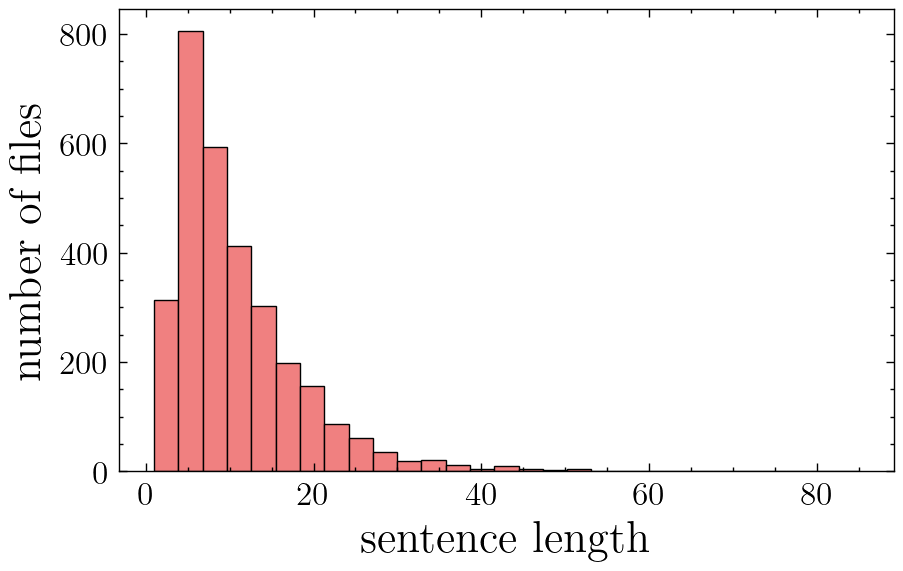

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))

pd.DataFrame.hist(
    data=dochka_sent_df,
    column='len',
    ax=ax,
    bins=29,
    legend=False,
    color='lightcoral',
    alpha=1,
    edgecolor='k',
    lw=0.5,
)

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.title(None)
plt.xlabel('sentence length', fontsize=lables_fs)
plt.ylabel('number of files', fontsize=lables_fs)

ax.grid(False)
plt.show()
# fig.savefig(f'figures/name.eps', format='eps')

### Punctuation tokenization

In [27]:
punct_to_token = {
    ' ' : 'S',  # space
    ',' : 'C',  # comma
    '.' : 'P',  # period
    '!' : 'EX', # exclamation
    '?' : 'Q'   # question
}

In [28]:
REMAIN_PUNCT = [',', '.', '!', '?']

#### Example

In [29]:
ind_sent = 124
raw_sent, proc_sent, len_sent = dochka_sent_df.iloc[ind_sent]
proc_sent

'зурин взглянул на часы, положил кий и объявил мне, что я проиграл сто рублей.'

In [30]:
words_sent = proc_sent

for mark in REMAIN_PUNCT:
    words_sent = words_sent.replace(mark, '')

words_sent  # INPUT for the prediction!

'зурин взглянул на часы положил кий и объявил мне что я проиграл сто рублей'

In [31]:
def tokenize(sentence, tokens_dict=punct_to_token):
    tokens_sent = []
    for word in sentence.split(' '):
        # print(word)
        if word[-1] not in tokens_dict.keys():
            tokens_sent.append(tokens_dict[' '])
        else:
            tokens_sent.append(tokens_dict[word[-1]])
    return ' '.join(tokens_sent)

In [32]:
tokenize(proc_sent)  # TARGET for the punctuation prediction

'S S S C S S S S C S S S S P'

In [33]:
assert len(tokenize(proc_sent).split(' ')) == len_sent

### Prepare all sentences and targets for further prediction

In [34]:
all_inputs = []
all_targets = []

for ind_row in tqdm(range(dochka_sent_df.shape[0])):
    sentence_this = dochka_sent_df.iloc[ind_row]['processed']

    input_this = sentence_this
    for mark in REMAIN_PUNCT:
        input_this = input_this.replace(mark, '')

    target_this = tokenize(sentence_this)

    assert len(target_this.split(' ')) == len(input_this.split(' '))
    
    all_inputs.append(input_this)
    all_targets.append(target_this)

100%|████████████████████████████████████| 3040/3040 [00:00<00:00, 28074.57it/s]


In [35]:
# add new rows to DF
dochka_sent_df['input'] = all_inputs
dochka_sent_df['target'] = all_targets

### Saving prepared data

In [36]:
dochka_sent_df.sample(10)

,raw,processed,len,input,target
1842,"«Ну, Савельич, — сказал я ему, — отдай же мне теперь половину; а остальное возьми себе.","ну, савельич, сказал я ему, отдай же мне теперь половину, а остальное возьми себе.",14,ну савельич сказал я ему отдай же мне теперь половину а остальное возьми себе,C C S S C S S S S C S S S P
2676,"Марья Ивановна приняла письмо дрожащею рукою и, заплакав, упала к ногам императрицы, которая подняла ее и поцеловала.","марья ивановна приняла письмо дрожащею рукою и, заплакав, упала к ногам императрицы, которая подняла ее и поцеловала.",17,марья ивановна приняла письмо дрожащею рукою и заплакав упала к ногам императрицы которая подняла ее и поцеловала,S S S S S S C C S S S C S S S S P
2659,"Камер-лакей объявил, что государыне угодно было, чтоб Марья Ивановна ехала одна и в том, в чем ее застанут.","камер-лакей объявил, что государыне угодно было, чтоб марья ивановна ехала одна и в том, в чем ее застанут.",18,камер-лакей объявил что государыне угодно было чтоб марья ивановна ехала одна и в том в чем ее застанут,S C S S S C S S S S S S S C S S S P
787,"Опустясь по крутой тропинке, мы остановились у самой реки и обнажили шпаги.","опустясь по крутой тропинке, мы остановились у самой реки и обнажили шпаги.",12,опустясь по крутой тропинке мы остановились у самой реки и обнажили шпаги,S S S C S S S S S S S P
1603,"Секретарь продолжал: — «Одеяло ситцевое, другое тафтяное на хлопчатой бумаге четыре рубля.","секретарь продолжал, одеяло ситцевое, другое тафтяное на хлопчатой бумаге четыре рубля.",11,секретарь продолжал одеяло ситцевое другое тафтяное на хлопчатой бумаге четыре рубля,S C S C S S S S S S P
559,"«Мне так сказывали в Оренбурге», — отвечал я.","мне так сказывали в оренбурге, отвечал я.",7,мне так сказывали в оренбурге отвечал я,S S S S C S P
2052,"— Я офицер и дворянин; вчера еще дрался противу тебя, а сегодня еду с тобой в одной кибитке, и счастие всей моей жизни зависит от тебя.","я офицер и дворянин, вчера еще дрался противу тебя, а сегодня еду с тобой в одной кибитке, и счастие всей моей жизни зависит от тебя.",25,я офицер и дворянин вчера еще дрался противу тебя а сегодня еду с тобой в одной кибитке и счастие всей моей жизни зависит от тебя,S S S C S S S S C S S S S S S S C S S S S S S S P
122,"Шары поминутно летали у меня через борт; я горячился, бранил маркера, который считал бог ведает как, час от часу умножал игру, словом — вел себя как мальчишка, вырвавшийся на волю.","шары поминутно летали у меня через борт, я горячился, бранил маркера, который считал бог ведает как, час от часу умножал игру, словом, вел себя как мальчишка, вырвавшийся на волю.",29,шары поминутно летали у меня через борт я горячился бранил маркера который считал бог ведает как час от часу умножал игру словом вел себя как мальчишка вырвавшийся на волю,S S S S S S C S C S C S S S S C S S S S C C S S S C S S P
678,"Мы условились драться за скирдами, что находились подле крепости, и явиться туда на другой день в седьмом часу утра.","мы условились драться за скирдами, что находились подле крепости, и явиться туда на другой день в седьмом часу утра.",19,мы условились драться за скирдами что находились подле крепости и явиться туда на другой день в седьмом часу утра,S S S S C S S S C S S S S S S S S S P
1607,"Признаюсь, я перепугался за бедного моего дядьку.","признаюсь, я перепугался за бедного моего дядьку.",7,признаюсь я перепугался за бедного моего дядьку,C S S S S S P


In [39]:
pushkin_prepared_dir = '../data/prepared/pushkin'
dochka_filename_csv = dochka_filename.split('.')[0] + '.csv'

In [40]:
# saving dataframe (only 'input' and 'target' columns)
dochka_sent_df[['input', 'target']].to_csv(os.path.join(pushkin_prepared_dir, dochka_filename_csv))